In [1]:

import pandas as pd  # Importowanie biblioteki pandas do pracy z danymi tabularnymi
import numpy as np

# Wczytanie danych z pliku CSV do DataFrame
df = pd.read_csv('szereg_czasowy.csv', sep=';', decimal=',')

# Zmiana nazw kolumn w DataFrame
df.rename(columns={"X1 Average User Number ": "X1"}, inplace=True)
df.rename(columns={"X2 L.DLPwr.Avg": "X2"}, inplace=True)
df.rename(columns={"Y L.UL.Interference.Avg": "Y"}, inplace=True)
df.rename(columns={"X3 RA Success Rate": "X3"}, inplace=True)
df.rename(columns={"X4 RRC Setup Success Rate (Service)": "X4"}, inplace=True)
df.rename(columns={"X5 TA Mean": "X5"}, inplace=True)

# Wybór pierwszych 12288 wierszy z DataFrame
df = df[0:12288]

# Wypełnienie brakujących danych w DataFrame wartościami z poprzednich wierszy
df = df.fillna(method='ffill')

# Konwersja kolumny 'Start' na typ datetime i utworzenie nowej kolumny 'Date'
df['Date'] = pd.to_datetime(df['Start'], format='%d.%m.%Y  %H:%M')

# Wybór tylko określonych kolumn w DataFrame
df = df[['Date', 'NE', 'X1', 'X2', 'X3', 'X4', 'X5', 'Y']]

# Wybór wierszy, które mają wartość 'NE' równą '44_KOS0015A_111L18_O_SLOWIANSKA'
df = df[df['NE'] == '44_KOS0015A_111L18_O_SLOWIANSKA']

# Wyświetlenie informacji o DataFrame
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 192 entries, 4032 to 4223
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    192 non-null    datetime64[ns]
 1   NE      192 non-null    object        
 2   X1      192 non-null    float64       
 3   X2      192 non-null    float64       
 4   X3      192 non-null    float64       
 5   X4      192 non-null    float64       
 6   X5      192 non-null    float64       
 7   Y       192 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 13.5+ KB


In [2]:
df.head()

,Date,NE,X1,X2,X3,X4,X5,Y
4032,2023-05-09 00:00:00,44_KOS0015A_111L18_O_SLOWIANSKA,14.0744,42.5,95.4206,100.0000,0.9321,-117.0
4033,2023-05-09 01:00:00,44_KOS0015A_111L18_O_SLOWIANSKA,13.3176,41.1,83.0103,99.8426,0.9625,-117.0
4034,2023-05-09 02:00:00,44_KOS0015A_111L18_O_SLOWIANSKA,12.5942,40.5,77.2693,99.9491,1.0792,-117.0
4035,2023-05-09 03:00:00,44_KOS0015A_111L18_O_SLOWIANSKA,22.1106,40.2,91.1665,99.9723,1.1067,-117.0
4036,2023-05-09 04:00:00,44_KOS0015A_111L18_O_SLOWIANSKA,21.9133,41.2,93.0696,99.9304,1.0485,-117.0


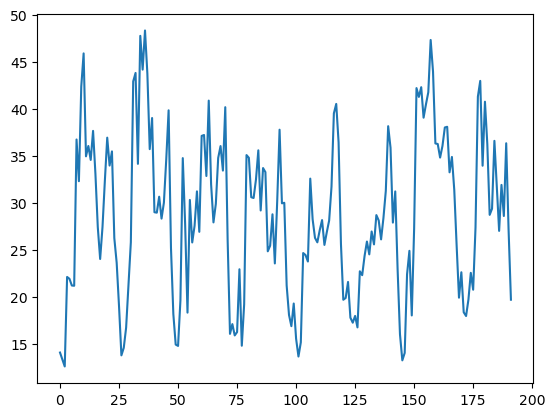

In [3]:
import matplotlib.pyplot as plt  # Importowanie biblioteki Matplotlib do tworzenia wykresów

timeseries = df[["X1"]].values.astype('float32')  # Wybór kolumny "X1" jako tablicy NumPy z wartościami typu float32
 
plt.plot(timeseries)  # Tworzenie wykresu liniowego na podstawie danych czasowych
plt.show()  # Wyświetlenie wykresu


In [4]:
train_size = int(len(timeseries) * 0.67)  # Obliczenie rozmiaru zestawu treningowego jako 67% całej długości danych
test_size = len(timeseries) - train_size  # Obliczenie rozmiaru zestawu testowego jako pozostała część danych

train, test = timeseries[:train_size], timeseries[train_size:]  # Podział danych na zestawy treningowe i testowe


In [5]:
import torch  # Importowanie biblioteki PyTorch

def create_dataset(dataset, lookback):
    X, y = [], []  # Inicjalizacja pustych list X (cechy) i y (etykiety)

    # Iteracja przez dane wejściowe w celu stworzenia próbek
    for i in range(len(dataset) - lookback):
        feature = dataset[i:i+lookback]  # Tworzenie cechy (historii) o długości "lookback"
        target = dataset[i+1:i+lookback+1]  # Tworzenie etykiety (wartości przyszłej) o długości "lookback"
        X.append(feature)  # Dodanie cechy do listy cech
        y.append(target)  # Dodanie etykiety do listy etykiet

    return torch.tensor(X), torch.tensor(y)  # Konwersja list do tensorów PyTorch i zwrócenie ich jako wynik funkcji


In [6]:
lookback = 24  # Długość historii (liczba punktów danych wstecz)

# Tworzenie zestawu treningowego
X_train, y_train = create_dataset(train, lookback=lookback)

# Tworzenie zestawu testowego
X_test, y_test = create_dataset(test, lookback=lookback)

# Wyświetlenie kształtu zestawów danych
print(X_train.shape, y_train.shape)  # Wyświetlenie kształtu zestawu treningowego
print(X_test.shape, y_test.shape)    # Wyświetlenie kształtu zestawu testowego


torch.Size([104, 24, 1]) torch.Size([104, 24, 1])
torch.Size([40, 24, 1]) torch.Size([40, 24, 1])


C:\Users\aniak\AppData\Local\Temp\ipykernel_10448\3760215335.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(X), torch.tensor(y)  # Konwersja list do tensorów PyTorch i zwrócenie ich jako wynik funkcji


In [7]:
import torch.nn as nn  # Importowanie modułu nn z PyTorch

# Definicja klasy TSModel, która dziedziczy po nn.Module
class TSModel(nn.Module):
    def __init__(self):
        super().__init__()  # Inicjalizacja klasy bazowej nn.Module

        # Warstwa LSTM (Long Short-Term Memory) dla modelu sekwencyjnego
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)

        # Warstwa liniowa (fully connected) do przewidywania wyniku
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)  # Przepływ danych przez warstwę LSTM
        x = self.linear(x)   # Przepływ danych przez warstwę liniową
        return x  # Zwrócenie wyniku


In [8]:
import torch.optim as optim  # Importowanie modułu optim z PyTorch
import torch.utils.data as data  # Importowanie modułu data z PyTorch

# Inicjalizacja modelu
model = TSModel()

# Inicjalizacja optymalizatora (Adam) i funkcji straty (Mean Squared Error)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

# Tworzenie DataLoader do ładowania danych treningowych w batchach
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000  # Liczba epok treningu
for epoch in range(n_epochs):
    model.train()  # Ustawienie modelu w tryb treningowy
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)  # Wykonanie predykcji
        loss = loss_fn(y_pred, y_batch)  # Obliczenie straty
        optimizer.zero_grad()  # Zresetowanie gradientów
        loss.backward()  # Wsteczna propagacja
        optimizer.step()  # Aktualizacja wag modelu

    if epoch % 100 != 0:  # Wyświetlanie wyników co 100 epok
        continue
    model.eval()  # Ustawienie modelu w tryb ewaluacji (bez uczenia)
    with torch.no_grad():
        y_pred = model(X_train)  # Wykonanie predykcji na danych treningowych
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))  # Obliczenie RMSE na danych treningowych
        y_pred = model(X_test)  # Wykonanie predykcji na danych testowych
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))  # Obliczenie RMSE na danych testowych
    print("Epoka %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))  # Wyświetlenie wyników


Epoka 0: train RMSE 28.9775, test RMSE 31.7973
Epoka 100: train RMSE 5.8210, test RMSE 6.5264
Epoka 200: train RMSE 4.4778, test RMSE 5.7504
Epoka 300: train RMSE 3.8289, test RMSE 6.2358
Epoka 400: train RMSE 3.5178, test RMSE 6.6113
Epoka 500: train RMSE 3.3144, test RMSE 6.8348
Epoka 600: train RMSE 3.1433, test RMSE 6.9641
Epoka 700: train RMSE 3.0068, test RMSE 6.8279
Epoka 800: train RMSE 2.8911, test RMSE 7.2402
Epoka 900: train RMSE 2.7505, test RMSE 7.2268
Epoka 1000: train RMSE 2.6295, test RMSE 7.4773
Epoka 1100: train RMSE 2.5680, test RMSE 7.4582
Epoka 1200: train RMSE 2.4352, test RMSE 7.4564
Epoka 1300: train RMSE 2.3305, test RMSE 7.5101
Epoka 1400: train RMSE 2.3023, test RMSE 7.2356
Epoka 1500: train RMSE 2.2054, test RMSE 7.4832
Epoka 1600: train RMSE 2.1393, test RMSE 7.6290
Epoka 1700: train RMSE 2.0749, test RMSE 7.6087
Epoka 1800: train RMSE 2.0169, test RMSE 7.7004
Epoka 1900: train RMSE 1.9690, test RMSE 7.6767


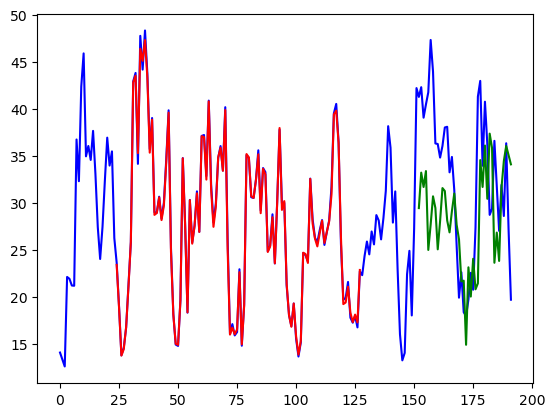

In [9]:
#Predykcja vs rzeczywistość
with torch.no_grad():
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]

    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()